<a href="https://colab.research.google.com/github/shreya0505/BTP_7thSem/blob/main/TSNE_Complete_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**
Download weights from this file to your google drive
https://drive.google.com/drive/folders/18zzpa11c66xgr9kfKZjuV6vL2lTVNnbQ?usp=sharing

Mount google drive to colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model

import numpy as np
import os
from glob import glob
import PIL
from PIL import Image
import zipfile
import random
import matplotlib.pyplot as plt

from shutil import copyfile

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# **Constants**

In [3]:
# PRETRAINED WEIGHTS
PRE_TRAINED_APPLE = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/apple.rar"
PRE_TRAINED_ORANGE = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/orange.rar"
PRE_TRAINED_CAT = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/cat.rar"
PRE_TRAINED_DOG = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/dog.rar"

WEIGHTS_FOLDER = '/tmp/weights/'

# APPLE AND ORANGE
SOURCE_DIR_APPLE2ORANGE = "/tmp/apple2orange"

APPLE_TEST_DIR = "/tmp/apple2orange/testA"
ORANGE_TEST_DIR = "/tmp/apple2orange/testB"

APPLE_TRAIN_DIR = "/tmp/apple2orange/trainA"
ORANGE_TRAIN_DIR = "/tmp/apple2orange/trainB"

APPLE_DATASET = "/tmp/dataset/apple/apple_images"
ORANGE_DATASET = "/tmp/dataset/orange/orange_images"
APPLE_DATASET_DIR = "/tmp/dataset/apple"
ORANGE_DATASET_DIR = "/tmp/dataset/orange"

WEIGHTS_APPLE = "/tmp/weights/apple/"
WEIGHTS_ORANGE = "/tmp/weights/orange/"


# CAT AND DOG
SOURCE_DIR_DOG2CAT = "/tmp/PetImages/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"

CATS_DIR = "/tmp/dataset/cat/cat_images"
CATS_PARENT_DIR = "/tmp/dataset/cat"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
DOGS_DIR = "/tmp/dataset/dog/dog_images"
DOGS_PARENT_DIR = "/tmp/dataset/dog"

WEIGHTS_CAT_DIR = "/tmp/weights/cat/"
WEIGHTS_DOG_DIR = "/tmp/weights/dog/"

In [4]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 200 # Dimension of the latent vector (z)
LEARNING_RATE = 0.0005
N_EPOCHS = 60

# **Model**

In [5]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

In [6]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)


# **Load Data**

In [7]:
def transfer_data(SOURCE, DESTINATION):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" + filename
        file_details = os.path.splitext(filename)
        if os.path.getsize(file) > 0:
          if file_details[1]=='.jpg':
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    for filename in files:
        this_file = SOURCE + "/" + filename
        destination = DESTINATION + "/" + filename
        copyfile(this_file, destination)

## **Apple and Orange**

In [8]:
# http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
!wget --no-check-certificate \
    "http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip" \
    -O "/tmp/apple2orange.zip"

local_zip = '/tmp/apple2orange.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-11-28 08:01:05--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘/tmp/apple2orange.zip’

/tmp/apple2orange.z 100%[===================>]  74.82M  2.53MB/s    in 34s     

2021-11-28 08:01:39 (2.20 MB/s) - ‘/tmp/apple2orange.zip’ saved [78456409/78456409]



In [9]:
if not os.path.exists(APPLE_DATASET):
  os.makedirs(APPLE_DATASET)

if not os.path.exists(ORANGE_DATASET):
  os.makedirs(ORANGE_DATASET)

In [10]:
transfer_data(ORANGE_TRAIN_DIR, ORANGE_DATASET )
transfer_data(ORANGE_TEST_DIR, ORANGE_DATASET )
IMAGES = os.listdir(ORANGE_DATASET)
print('There are',len(IMAGES),'orange images. Here are 5 example filesnames:')
print(IMAGES[:5])

transfer_data(APPLE_TRAIN_DIR, APPLE_DATASET )
transfer_data(APPLE_TEST_DIR, APPLE_DATASET )
IMAGES = os.listdir(APPLE_DATASET)
print('There are',len(IMAGES),'apple images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 1267 orange images. Here are 5 example filesnames:
['n07749192_4899.jpg', 'n07749192_4313.jpg', 'n07749192_10355.jpg', 'n07749192_3220.jpg', 'n07749192_7011.jpg']
There are 1261 apple images. Here are 5 example filesnames:
['n07740461_6735.jpg', 'n07740461_166.jpg', 'n07740461_4927.jpg', 'n07740461_4884.jpg', 'n07740461_11117.jpg']


In [11]:
NUM_IMAGES = len(os.listdir(ORANGE_DATASET))
orange_data_flow = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(ORANGE_DATASET_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 1267 images belonging to 1 classes.


In [12]:
NUM_IMAGES = len(os.listdir(APPLE_DATASET))
apple_data_flow = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(APPLE_DATASET_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 1261 images belonging to 1 classes.


## **Cat and Dog**

In [13]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-11-28 08:01:41--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.46.196.215, 2600:1407:3c00:108c::e59, 2600:1407:3c00:10a2::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.46.196.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  98.4MB/s    in 8.2s    

2021-11-28 08:01:50 (95.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [14]:
if not os.path.exists(CATS_DIR):
  os.makedirs(CATS_DIR)

if not os.path.exists(DOGS_DIR):
  os.makedirs(DOGS_DIR)

In [15]:
transfer_data(DOG_SOURCE_DIR, DOGS_DIR )
IMAGES = os.listdir(DOGS_DIR)
print('There are',len(IMAGES),'dog images. Here are 5 example filesnames:')
print(IMAGES[:5])

transfer_data(CAT_SOURCE_DIR, CATS_DIR )
IMAGES = os.listdir(CATS_DIR)
print('There are',len(IMAGES),'cat images. Here are 5 example filesnames:')
print(IMAGES[:5])

11702.jpg is zero length, so ignoring.
There are 12499 dog images. Here are 5 example filesnames:
['7184.jpg', '9937.jpg', '10679.jpg', '11116.jpg', '5259.jpg']
666.jpg is zero length, so ignoring.
There are 12499 cat images. Here are 5 example filesnames:
['7184.jpg', '9937.jpg', '10679.jpg', '11116.jpg', '5259.jpg']


In [16]:
data_flow_dogs = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(DOGS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 12499 images belonging to 1 classes.


In [17]:
data_flow_cats = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(CATS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 12499 images belonging to 1 classes.


# **Load Pretrained Models**

In [18]:
if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(WEIGHTS_FOLDER)

## **Dog**

In [19]:
encoder_input, encoder_output,  shape_before_flattening, dog_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

dog_encoder.summary()

decoder_input, decoder_output, dog_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
dog_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = dog_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
dog_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

dog_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [20]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/dog.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/dog.rar

Creating    /tmp/weights/dog                                          OK
Extracting  /tmp/weights/dog/.data-00000-of-00001                         20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/dog/.index                                       99%  OK 
Extracting  /tmp/weights/dog/checkpoint                                   99%  OK 
All OK


In [21]:
dog_simple_autoencoder.load_weights(WEIGHTS_DOG_DIR)

## **Cat**

In [22]:
encoder_input, encoder_output,  shape_before_flattening, cat_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

cat_encoder.summary()

decoder_input, decoder_output, cat_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
cat_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = cat_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
cat_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

cat_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [23]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/cat.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/cat.rar

Creating    /tmp/weights/cat                                          OK
Extracting  /tmp/weights/cat/.data-00000-of-00001                         20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/cat/.index                                       99%  OK 
Extracting  /tmp/weights/cat/checkpoint                                   99%  OK 
All OK


In [24]:
cat_simple_autoencoder.load_weights(WEIGHTS_CAT_DIR)

## **Apple**

In [25]:
encoder_input, encoder_output,  shape_before_flattening, apple_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

apple_encoder.summary()

decoder_input, decoder_output, apple_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
apple_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = apple_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
apple_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

apple_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [26]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/apple.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/apple.rar

Creating    /tmp/weights/apple                                        OK
Extracting  /tmp/weights/apple/.data-00000-of-00001                       20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/apple/.index                                     99%  OK 
Extracting  /tmp/weights/apple/checkpoint                                 99%  OK 
All OK


In [27]:
apple_simple_autoencoder.load_weights(WEIGHTS_APPLE)


## **Orange** 

In [28]:
encoder_input, encoder_output,  shape_before_flattening, orange_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

orange_encoder.summary()

decoder_input, decoder_output, orange_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
orange_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = orange_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
orange_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

orange_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [29]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/orange.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/orange.rar

Creating    /tmp/weights/orange (2)                                   OK
Extracting  /tmp/weights/orange (2)/.data-00000-of-00001                  20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/orange (2)/.index                                99%  OK 
Extracting  /tmp/weights/orange (2)/checkpoint                            99%  OK 
All OK


In [31]:
orange_simple_autoencoder.load_weights(WEIGHTS_ORANGE)

# **Results**

In [32]:
def plot_compare(images=None, add_noise=False, encoder=None, decoder=None, simple_autoencoder=None):
  
  if ( (images is None) or (encoder is None) or (decoder is None) or (simple_autoencoder is None)):
    print("Invalid Inputs")
    raise ValueError

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

## **Expected Input**

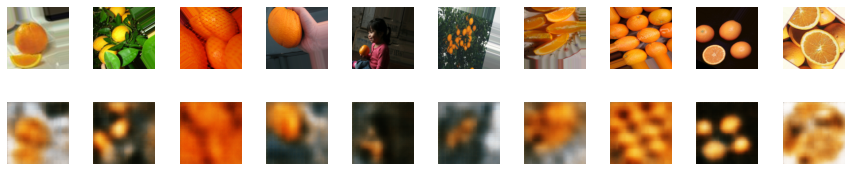

In [55]:
orange_batch = next(orange_data_flow)
orange_batch = orange_batch[0]
orange_images = orange_batch[:10]

plot_compare(orange_images, False, orange_encoder, orange_decoder, orange_simple_autoencoder)

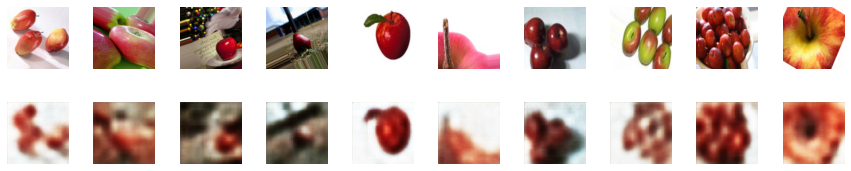

In [56]:
apple_batch = next(apple_data_flow)
apple_batch = apple_batch[0]
apple_images = apple_batch[:10]

plot_compare(apple_images, False, apple_encoder, apple_decoder, apple_simple_autoencoder)

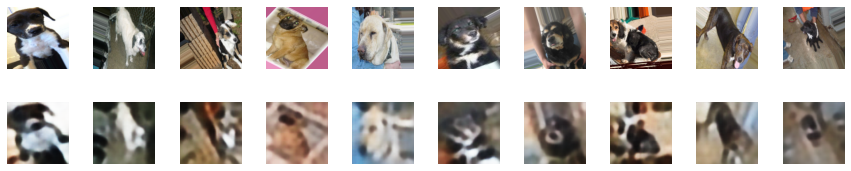

In [57]:
dog_batch = next(data_flow_dogs)
dog_batch = dog_batch[0]
dog_images = dog_batch[:10]

plot_compare(dog_images, False, dog_encoder, dog_decoder, dog_simple_autoencoder)

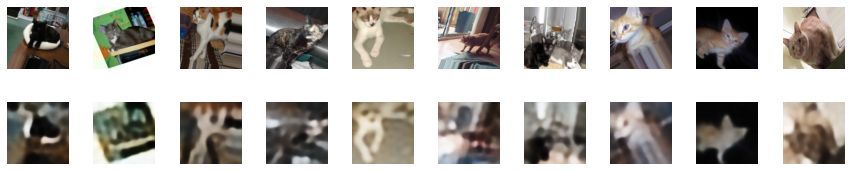

In [58]:
cat_batch = next(data_flow_cats)
cat_batch = cat_batch[0]
cat_images = cat_batch[:10]

plot_compare(cat_images, False, cat_encoder, cat_decoder, cat_simple_autoencoder)

## **Swapped Input**

In [60]:
print(apple_images.shape, orange_images.shape, cat_images.shape, dog_images.shape)

(10, 128, 128, 3) (10, 128, 128, 3) (10, 128, 128, 3) (10, 128, 128, 3)


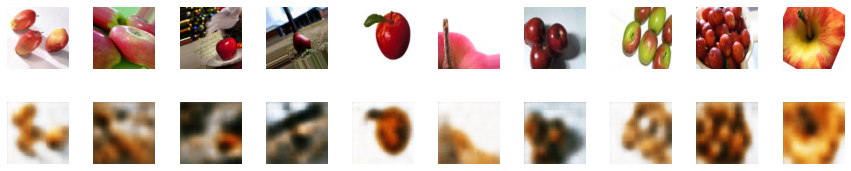

In [61]:
plot_compare(apple_images, False, orange_encoder, orange_decoder, orange_simple_autoencoder)

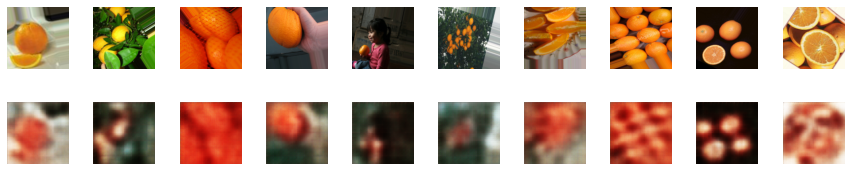

In [62]:
plot_compare(orange_images, False, apple_encoder, apple_decoder, apple_simple_autoencoder)

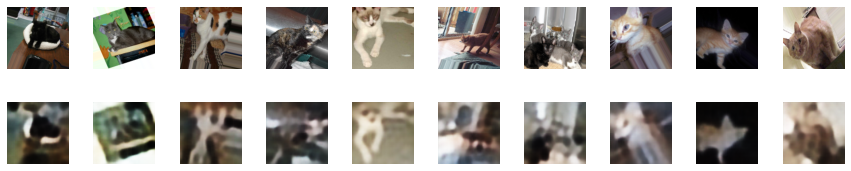

In [63]:
plot_compare(cat_images, False, dog_encoder, dog_decoder, dog_simple_autoencoder)

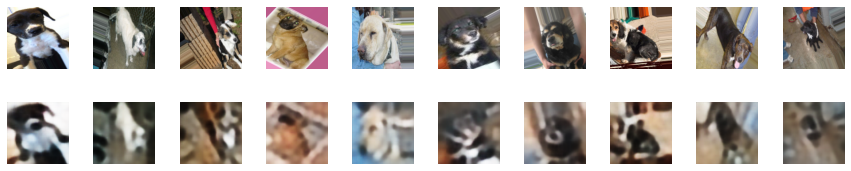

In [64]:
plot_compare(dog_images, False, cat_encoder, cat_decoder, cat_simple_autoencoder)

# **Analysis**
Get data points

In [67]:
data_flow_dogs = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(DOGS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = 2500,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

dogs_batch = next(data_flow_dogs)                                                                           
dog_images = dogs_batch[1]
dog_images.shape

Found 12499 images belonging to 1 classes.


(2500, 128, 128, 3)

In [68]:
data_flow_cats = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(CATS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = 2500,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)
                                    
cats_batch = next(data_flow_cats)                                                                           
cat_images = cats_batch[1]
cat_images.shape

Found 12499 images belonging to 1 classes.


(2500, 128, 128, 3)

In [69]:
orange_data_flow = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(ORANGE_DATASET_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = 1000,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)
                                    
orange_batch = next(orange_data_flow)                                                                           
orange_images = orange_batch[1]
orange_images.shape

Found 1267 images belonging to 1 classes.


(1000, 128, 128, 3)

In [70]:
apple_data_flow = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(APPLE_DATASET_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = 1000,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)
apple_batch = next(apple_data_flow)                                                                           
apple_images = apple_batch[1]
apple_images.shape

Found 1261 images belonging to 1 classes.


(1000, 128, 128, 3)

## **TSNE Plots**

In [91]:
from sklearn.manifold import TSNE
import pandas as pd  
import seaborn as sns
import plotly.express as px

### **Dogs**

In [74]:
encodings_dogs = dog_encoder.predict(dog_images)

2D Plot

In [75]:
tsne_dogs_2D = TSNE(2, verbose=1)
tsne_dogs_proj_2D = tsne_dogs_2D.fit_transform(encodings_dogs)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 4.488587
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.495209
[t-SNE] KL divergence after 1000 iterations: 2.687712


In [113]:
df_2D_dogs = pd.DataFrame()
df_2D_dogs["Component_1"] = tsne_dogs_proj_2D[:,0]
df_2D_dogs["Component_2"] = tsne_dogs_proj_2D[:,1]
df_2D_dogs["y"] = ["0"] * 2500

[Text(0.5, 1.0, 'T-SNE projection')]

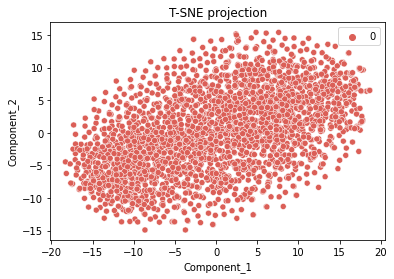

In [114]:
sns.scatterplot(x="Component_1", y="Component_2", hue=df_2D_dogs.y.tolist(),
                palette=sns.color_palette("hls", 1),
                data=df_2D_dogs).set(title="T-SNE projection")

3D Plot

In [102]:
tsne_dogs_3D = TSNE(3, verbose=1)
tsne_dogs_proj_3D = tsne_dogs_3D.fit_transform(encodings_dogs)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.003s...
[t-SNE] Computed neighbors for 2500 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 4.488587
[t-SNE] KL divergence after 250 iterations with early exaggeration: 135.605591
[t-SNE] KL divergence after 1000 iterations: 3.458730


In [103]:
df_3D_dogs = pd.DataFrame()
df_3D_dogs["Component_1"] = tsne_dogs_proj_3D[:,0]
df_3D_dogs["Component_2"] = tsne_dogs_proj_3D[:,1]
df_3D_dogs["Component_3"] = tsne_dogs_proj_3D[:,2]
df_3D_dogs["y"] = ["0"] * 2500

In [ ]:
fig = px.scatter_3d(
    tsne_dogs_proj_3D, x=0, y=1, z=2,
    color=df_3D_dogs.y, labels={'color': 'y'}
)
fig.update_traces(marker_size=8)
fig.show()

### Cats

In [106]:
encodings_cats = cat_encoder.predict(cat_images)

2D Plots

In [107]:
tsne_cats_2D = TSNE(2, verbose=1)
tsne_cats_proj_2D = tsne_cats_2D.fit_transform(encodings_cats)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.006s...
[t-SNE] Computed neighbors for 2500 samples in 0.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 5.017231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.108734
[t-SNE] KL divergence after 1000 iterations: 2.641723


In [111]:
df_2D_cats = pd.DataFrame()
df_2D_cats["Component_1"] = tsne_cats_proj_2D[:,0]
df_2D_cats["Component_2"] = tsne_cats_proj_2D[:,1]
df_2D_cats["y"] = ["1"] * 2500

[Text(0.5, 1.0, 'T-SNE projection')]

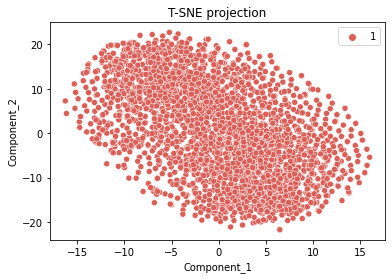

In [112]:
sns.scatterplot(x="Component_1", y="Component_2", hue=df_2D_cats.y.tolist(),
                palette=sns.color_palette("hls", 1),
                data=df_2D_cats).set(title="T-SNE projection")

3D Plot

In [115]:
tsne_cats_3D = TSNE(3, verbose=1)
tsne_cats_proj_3D = tsne_cats_3D.fit_transform(encodings_cats)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 5.017231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 134.936401
[t-SNE] KL divergence after 1000 iterations: 3.263153


In [130]:
df_3D_cats = pd.DataFrame()
df_3D_cats["Component_1"] = tsne_cats_proj_3D[:,0]
df_3D_cats["Component_2"] = tsne_cats_proj_3D[:,1]
df_3D_cats["Component_3"] = tsne_cats_proj_3D[:,2]
df_3D_cats["y"] = ["1"] * 2500

In [ ]:
fig = px.scatter_3d(
    tsne_cats_proj_3D, x=0, y=1, z=2,
    color=df_3D_cats.y, labels={'color': 'y'}
)
fig.update_traces(marker_size=8)
fig.show()

### Combined Cats and Dogs

2D

In [119]:
cat_dog_df_2D = pd.DataFrame()
cat_dog_df_2D = cat_dog_df_2D.append(df_2D_dogs)
cat_dog_df_2D = cat_dog_df_2D.append(df_2D_cats)

[Text(0.5, 1.0, 'T-SNE projection')]

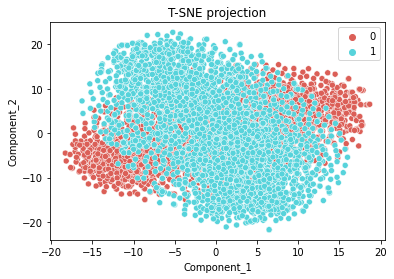

In [120]:
sns.scatterplot(x="Component_1", y="Component_2", hue=cat_dog_df_2D.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=cat_dog_df_2D).set(title="T-SNE projection")

3D

In [135]:
cat_dog_df_3D = pd.DataFrame()
cat_dog_df_3D = cat_dog_df_3D.append(df_3D_dogs)
cat_dog_df_3D = cat_dog_df_3D.append(df_3D_cats)
tsne_cats_dogs_3D = np.append(tsne_cats_proj_3D,tsne_dogs_proj_3D, axis=0)
tsne_cats_dogs_3D.shape

(5000, 3)

In [ ]:
fig = px.scatter_3d(
    tsne_cats_dogs_3D, x=0, y=1, z=2,
    color=cat_dog_df_3D.y, labels={'color': 'y'}
)
fig.update_traces(marker_size=8)
fig.show()

### Apple

In [139]:
encodings_apple = apple_encoder.predict(apple_images)

2D Plot

In [148]:
tsne_apple_2D = TSNE(2, verbose=1)
tsne_apple_proj_2D = tsne_apple_2D.fit_transform(encodings_apple)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 9.661154
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.260056
[t-SNE] KL divergence after 1000 iterations: 1.441147


In [150]:
df_2D_apple = pd.DataFrame()
df_2D_apple["Component_1"] = tsne_apple_proj_2D[:,0]
df_2D_apple["Component_2"] = tsne_apple_proj_2D[:,1]
df_2D_apple["y"] = ["1"] * 1000

[Text(0.5, 1.0, 'T-SNE projection')]

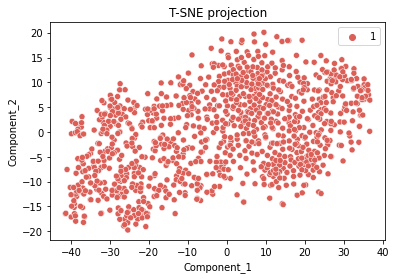

In [151]:
sns.scatterplot(x="Component_1", y="Component_2", hue=df_2D_apple.y.tolist(),
                palette=sns.color_palette("hls", 1),
                data=df_2D_apple).set(title="T-SNE projection")

3D Plot

In [152]:
tsne_apple_3D = TSNE(3, verbose=1)
tsne_apple_proj_3D = tsne_apple_3D.fit_transform(encodings_apple)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 9.661154
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.243637
[t-SNE] KL divergence after 1000 iterations: 1.948862


In [154]:
df_3D_apple = pd.DataFrame()
df_3D_apple["Component_1"] = tsne_apple_proj_3D[:,0]
df_3D_apple["Component_2"] = tsne_apple_proj_3D[:,1]
df_3D_apple["Component_3"] = tsne_apple_proj_3D[:,2]
df_3D_apple["y"] = ["1"] * 1000

In [ ]:
fig = px.scatter_3d(
    tsne_apple_proj_3D, x=0, y=1, z=2,
    color=df_3D_apple.y, labels={'color': 'y'}
)
fig.update_traces(marker_size=8)
fig.show()

### Orange

In [140]:
encodings_orange = orange_encoder.predict(orange_images)

2D Plot

In [141]:
tsne_orange_2D = TSNE(2, verbose=1)
tsne_orange_proj_2D = tsne_orange_2D.fit_transform(encodings_orange)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.280178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.287888
[t-SNE] KL divergence after 1000 iterations: 1.492822


In [143]:
df_2D_orange = pd.DataFrame()
df_2D_orange["Component_1"] = tsne_orange_proj_2D[:,0]
df_2D_orange["Component_2"] = tsne_orange_proj_2D[:,1]
df_2D_orange["y"] = ["0"] * 1000

[Text(0.5, 1.0, 'T-SNE projection')]

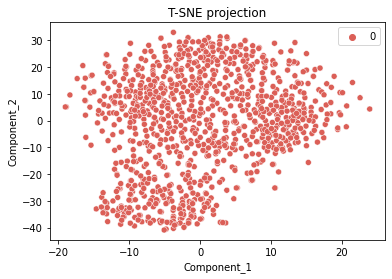

In [144]:
sns.scatterplot(x="Component_1", y="Component_2", hue=df_2D_orange.y.tolist(),
                palette=sns.color_palette("hls", 1),
                data=df_2D_orange).set(title="T-SNE projection")

3D Plot

In [145]:
tsne_orange_3D = TSNE(3, verbose=1)
tsne_orange_proj_3D = tsne_orange_3D.fit_transform(encodings_orange)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.280178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.860947
[t-SNE] KL divergence after 1000 iterations: 2.146984


In [146]:
df_3D_orange = pd.DataFrame()
df_3D_orange["Component_1"] = tsne_orange_proj_3D[:,0]
df_3D_orange["Component_2"] = tsne_orange_proj_3D[:,1]
df_3D_orange["Component_3"] = tsne_orange_proj_3D[:,2]
df_3D_orange["y"] = ["0"] * 1000

In [ ]:
fig = px.scatter_3d(
    tsne_orange_proj_3D, x=0, y=1, z=2,
    color=df_3D_orange.y, labels={'color': 'y'}
)
fig.update_traces(marker_size=8)
fig.show()

### Combined Apple and Oranges

2D Plot

In [156]:
apple_orange_df_2D = pd.DataFrame()
apple_orange_df_2D = apple_orange_df_2D.append(df_2D_apple)
apple_orange_df_2D = apple_orange_df_2D.append(df_2D_orange)

[Text(0.5, 1.0, 'T-SNE projection')]

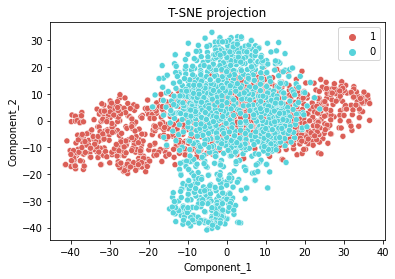

In [157]:
sns.scatterplot(x="Component_1", y="Component_2", hue=apple_orange_df_2D.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=apple_orange_df_2D).set(title="T-SNE projection")

3D Plot

In [158]:
apple_orange_df_3D = pd.DataFrame()
apple_orange_df_3D = apple_orange_df_3D.append(df_3D_apple)
apple_orange_df_3D = apple_orange_df_3D.append(df_3D_orange)
tsne_orange_apple_3D = np.append(tsne_orange_proj_3D,tsne_apple_proj_3D, axis=0)
tsne_orange_apple_3D.shape

(2000, 3)

In [159]:
fig = px.scatter_3d(
    tsne_orange_apple_3D, x=0, y=1, z=2,
    color=apple_orange_df_3D.y, labels={'color': 'y'}
)
fig.update_traces(marker_size=8)
fig.show()